## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [2]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [3]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [4]:
def AgeAndRHR(metadata, filename):
    """
    Calculate the age group, sex, and resting heart rate (RHR) of a subject based on heart rate timeseries data and metadata.

    Args:
    -----------
    metadata : pandas.DataFrame
        A DataFrame containing metadata about subjects. The DataFrame must include the columns 'subject', 'age', and 'sex'.
    filename : str
        The path to a .npz file containing heart rate timeseries data. The heart rate data should be stored under the key 'hr'.

    Returns:
    --------
    tuple
        A tuple containing three elements:
        - age_group (str or int): The age group of the subject as specified in the metadata.
        - sex (str): The sex of the subject as specified in the metadata.
        - rhr (float): The resting heart rate of the subject, calculated as the 5th percentile of the heart rate timeseries data.
    """

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = os.path.splitext(os.path.basename(filename))[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata['subject'] == subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata['subject'] == subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [5]:
df.head()

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 3 columns):
age_group    1537 non-null object
sex          1537 non-null object
rhr          1537 non-null float64
dtypes: float64(1), object(2)
memory usage: 36.1+ KB


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

In [13]:
# !pip install seaborn==0.9.0

    100% |████████████████████████████████| 215kB 3.5MB/s ta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1


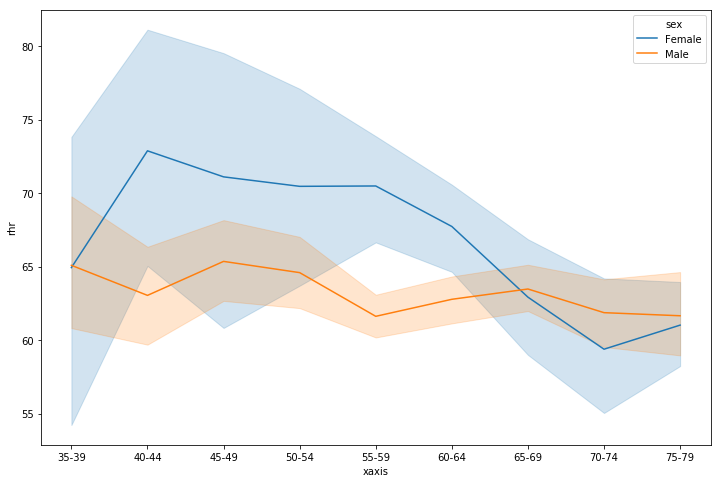

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see .... 
> 2. For men, we see ... 
> 3. In comparison to men, women's heart rate is .... 
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

## Clinical Conclusion

### 1. For women, we see...

Women generally exhibit higher resting heart rates across various age groups, particularly noticeable from ages 35 to 69. However, there is significant variability in heart rates among women, suggesting a diverse range of physiological responses.

### 2.For men, we see...

Men show a more stable pattern in heart rates, with relatively lower variation compared to women. The average heart rate for men remains consistent from ages 35 to 79, indicating a steadier physiological response across these age ranges.

### 3. In comparison to men, women's heart rate is...

On average, higher than that of men across most age groups observed. This difference may be attributed to factors such as differences in heart size and hormonal influences, which affect cardiac performance and heart rate regulation.

### 4. What are some possible reasons for what we see in our data?

1. **Physiological Differences**: Women generally have smaller heart sizes compared to men, which may require more frequent contractions to maintain blood circulation.

2. **Hormonal and Metabolic Factors**: Variability in women's heart rates could be influenced by hormonal fluctuations across menstrual cycles and menopausal transitions, affecting cardiovascular function.

3. **Sample Size and Data Variability**: The observed variability in women's heart rates may also stem from smaller sample sizes compared to men, potentially skewing the distribution and statistical measures.

### 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?

1. **Increase Sample Diversity**: Collect data from a more diverse population, including different geographical regions, ethnicities, and socio-economic backgrounds, to generalize findings and reduce bias.

2. **Incorporate Lifestyle Factors**: Gather information on daily activity levels, diet habits, and existing health conditions to better understand their influence on heart rate variability.

3. **Utilize Advanced Analytical Methods**: Apply machine learning algorithms to identify additional features and patterns in the data that traditional statistical methods may overlook, improving accuracy and predictive power.

### 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

While the data shows a trend of increasing heart rate until middle age and a subsequent decrease into old age, the validation of this trend requires further scrutiny:

- **Validation Constraints**: Limited sample sizes and potential biases in the dataset prevent definitive conclusions. More extensive data collection across diverse demographics and longitudinal studies would provide a more robust validation of age-related heart rate trends.

- **Insights from Current Data**: Despite limitations, the current data suggest a plausible trend of increasing heart rate until middle age, possibly influenced by physiological aging processes, and a subsequent decline in older age groups.
